In [14]:
# from burgers_ic_bc_data import burgers_data

# Setting initial and boundary conditions
# PINN for Burgers' equation (L-BFGS version)
# coded by St.Watermelon

import tensorflow as tf
import numpy as np

def burgers_data():

    # set number of data points
    N_b = 500    # boundary
    N_t = 500    # initial time
    N_c = 20000  # collocation point

    # set boundary
    xmin = -1.0
    xmax = 1.0
    tmin = 0.0
    tmax = 1.0

    # initial condition
    initial_xt = np.linspace([xmin, tmin], [xmax, tmin], N_t)
    initial_u = -np.sin(np.pi * initial_xt[:,0]).reshape(-1,1)

    # boundary condition
    boundary_up = np.linspace([xmax, tmin], [xmax, tmax], N_b)
    boundary_up_sol = np.zeros((N_b, 1))
    boundary_down = np.linspace([xmin, tmin], [xmin, tmax], N_b)
    boundary_down_sol = np.zeros((N_b, 1))

    # collection of initial and boundary condition
    xt_bnd = np.concatenate([initial_xt, boundary_up, boundary_down], axis=0)
    u_bnd_sol = np.concatenate([initial_u, boundary_up_sol, boundary_down_sol], axis=0)


    # collocation point
    t_col_data = np.random.uniform(tmin, tmax, [N_c, 1])
    x_col_data = np.random.uniform(xmin, xmax, [N_c, 1])
    xt_col_data = np.concatenate([x_col_data, t_col_data], axis=1)
    xt_col = np.concatenate((xt_col_data, xt_bnd), axis=0)

    # convert all to tensors
    xt_col = tf.convert_to_tensor(xt_col, dtype=tf.float32)
    xt_bnd = tf.convert_to_tensor(xt_bnd, dtype=tf.float32)
    u_bnd_sol = tf.convert_to_tensor(u_bnd_sol, dtype=tf.float32)

    return xt_col, xt_bnd, u_bnd_sol

In [19]:
# burgers_model_lbfgs.py

# PINN for Burgers' equation (L-BFGS anf tf.gradient version)
# coded by St.Watermelon

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
from time import time

# from burgers_ic_bc_data import burgers_data

class Burgers(Model):

    def __init__(self):
        super(Burgers, self).__init__()

        initializer = tf.keras.initializers.GlorotUniform

        self.h1 = Dense(20, activation='tanh', kernel_initializer=initializer)
        self.h2 = Dense(20, activation='tanh', kernel_initializer=initializer)
        self.h3 = Dense(20, activation='tanh', kernel_initializer=initializer)
        self.h4 = Dense(20, activation='tanh', kernel_initializer=initializer)
        self.h5 = Dense(20, activation='tanh', kernel_initializer=initializer)
        self.h6 = Dense(20, activation='tanh', kernel_initializer=initializer)
        self.u = Dense(1, activation='linear')


    def call(self, state):
        x = self.h1(state)
        x = self.h2(x)
        x = self.h3(x)
        x = self.h4(x)
        x = self.h5(x)
        x = self.h6(x)
        out = self.u(x)
        return out


class BurgersPinn(object):

    def __init__(self):

        self.lr = 0.001
        self.opt = Adam(self.lr)

        self.burgers = Burgers()
        self.burgers.build(input_shape=(None, 2))

        self.train_loss_history = []
        self.iter_count = 0
        self.instant_loss = 0

    @tf.function
    def physics_net(self, xt):
        x = xt[:, 0:1]
        t = xt[:, 1:2]
        xt_t = tf.concat([x, t], 1)
        u = self.burgers(xt_t)
        u_x = tf.gradients(u, x)
        u_xx = tf.gradients(u_x, x)
        u_t = tf.gradients(u, t)

        return u_t + u*u_x - (0.01/tf.constant(np.pi))*u_xx


    def save_weights(self, path):
        self.burgers.save_weights(path + 'burgers3.weights.h5')


    def load_weights(self, path):
        self.burgers.load_weights(path + 'burgers3.weights.h5')


    def compute_loss(self, f, u_bnd_hat, u_bnd_sol):

        loss_col = tf.reduce_mean(tf.square(f))
        loss_bnd = tf.reduce_mean(tf.square(u_bnd_hat - u_bnd_sol))

        loss = loss_col + loss_bnd

        return loss



    def compute_grad(self, xt_col, xt_bnd, u_bnd_sol):
        with tf.GradientTape() as tape:
            f = self.physics_net(xt_col)
            u_bnd_hat = self.burgers(xt_bnd)

            loss = self.compute_loss(f, u_bnd_hat, u_bnd_sol)

        grads = tape.gradient(loss, self.burgers.trainable_variables)

        return loss, grads


    def callback(self, arg=None):
        if self.iter_count % 10 == 0:
            print('iter=', self.iter_count, ', loss=', self.instant_loss)
            self.train_loss_history.append([self.iter_count, self.instant_loss])
        self.iter_count += 1



    def train_with_adam(self, xt_col, xt_bnd, u_bnd_sol, adam_num):

        def learn():
            loss, grads = self.compute_grad(xt_col, xt_bnd, u_bnd_sol)

            self.opt.apply_gradients(zip(grads, self.burgers.trainable_variables))

            return loss

        for iter in range(int(adam_num)):

            loss = learn()

            self.instant_loss = loss.numpy()
            self.callback()


    def train_with_lbfgs(self, xt_col, xt_bnd, u_bnd_sol, lbfgs_num):

        def vec_weight():
            # vectorize weights
            weight_vec = []

            # Loop over all weights
            for v in self.burgers.trainable_variables:
                weight_vec.extend(v.numpy().flatten())

            weight_vec = tf.convert_to_tensor(weight_vec)
            return weight_vec
        w0 = vec_weight().numpy()

        def restore_weight(weight_vec):
            # restore weight vector to model weights
            idx = 0
            for v in self.burgers.trainable_variables:
                vs = v.shape

                # weight matrices
                if len(vs) == 2:
                    sw = vs[0] * vs[1]
                    updated_val = tf.reshape(weight_vec[idx:idx + sw], (vs[0], vs[1]))
                    idx += sw

                # bias vectors
                elif len(vs) == 1:
                    updated_val = weight_vec[idx:idx + vs[0]]
                    idx += vs[0]

                # assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(updated_val, dtype=tf.float32))


        def loss_grad(w):
            # update weights in model
            restore_weight(w)
            loss, grads = self.compute_grad(xt_col, xt_bnd, u_bnd_sol)
            # vectorize gradients
            grad_vec = []
            for g in grads:
                grad_vec.extend(g.numpy().flatten())

            # gradient list to array
            # scipy-routines requires 64-bit floats
            loss = loss.numpy().astype(np.float64)
            self.instant_loss = loss
            grad_vec = np.array(grad_vec, dtype=np.float64)

            return loss, grad_vec

        return scipy.optimize.minimize(fun=loss_grad,
                                       x0=w0,
                                       jac=True,
                                       method='L-BFGS-B',
                                       callback=self.callback,
                                       options={'maxiter': lbfgs_num,
                                                'maxfun': 50000,
                                                'maxcor': 50,
                                                'maxls': 50,
                                                'ftol': 1.0 * np.finfo(float).eps})


    def predict(self, xt):
        u_pred = self.burgers(xt)
        return u_pred


    def train(self, adam_num, lbfgs_num):

        xt_col, xt_bnd, u_bnd_sol = burgers_data()

        # Start timer
        t0 = time()
        self.train_with_adam(xt_col, xt_bnd, u_bnd_sol, adam_num)
        # Print computation time
        print('\nComputation time of adam: {} seconds'.format(time() - t0))
        t1 = time()
        self.train_with_lbfgs(xt_col, xt_bnd, u_bnd_sol, lbfgs_num)
        # Print computation time
        print('\nComputation time of L-BFGS-B: {} seconds'.format(time() - t1))

        self.save_weights("./save_weights/")

        np.savetxt('./save_weights/loss3.txt', self.train_loss_history)
        train_loss_history = np.array(self.train_loss_history)

        plt.plot(train_loss_history[:, 0], train_loss_history[:, 1])
        plt.yscale("log")
        plt.show()

/Users/jinwoo/workspace/PINN-Tutorial/pinn_tutorial/lib/python3.11/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'burgers_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


iter= 0 , loss= 0.16622338
iter= 10 , loss= 0.14718933
iter= 20 , loss= 0.14574313
iter= 30 , loss= 0.14309931
iter= 40 , loss= 0.13709533
iter= 50 , loss= 0.12498099
iter= 60 , loss= 0.10506063
iter= 70 , loss= 0.091453314
iter= 80 , loss= 0.084831774
iter= 90 , loss= 0.08027221

Computation time of adam: 6.166877031326294 seconds
iter= 100 , loss= 0.07600857317447662
iter= 110 , loss= 0.07075969874858856
iter= 120 , loss= 0.06666481494903564
iter= 130 , loss= 0.062231793999671936
iter= 140 , loss= 0.05755632370710373
iter= 150 , loss= 0.05076294764876366
iter= 160 , loss= 0.04815812036395073
iter= 170 , loss= 0.0463985949754715
iter= 180 , loss= 0.044481709599494934
iter= 190 , loss= 0.04290729761123657
iter= 200 , loss= 0.03979700803756714
iter= 210 , loss= 0.037150293588638306
iter= 220 , loss= 0.03578944504261017
iter= 230 , loss= 0.03446607664227486
iter= 240 , loss= 0.03379221633076668
iter= 250 , loss= 0.0314682312309742
iter= 260 , loss= 0.029239676892757416
iter= 270 , loss= 

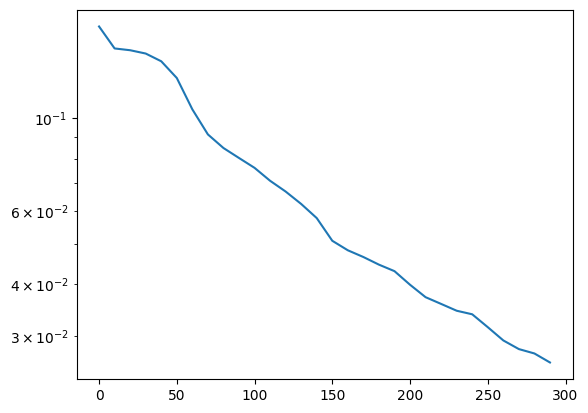

In [20]:
# main
def main():

    adam_num = 100
    lbfgs_num = 200
    agent = BurgersPinn()

    agent.train(adam_num, lbfgs_num)


if __name__=="__main__":
    main()

/Users/jinwoo/workspace/PINN-Tutorial/pinn_tutorial/lib/python3.11/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'burgers_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


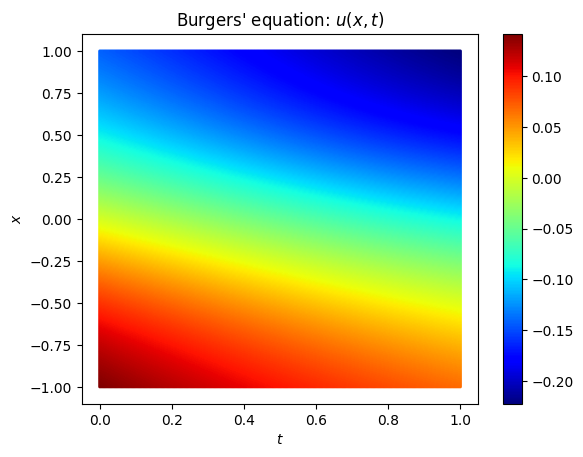

In [21]:
# load_eval_map.py

# from burgers_model_lbfgs import *
import matplotlib.pyplot as plt

agent = BurgersPinn()
agent.load_weights('./save_weights/')

# data for validation
x_input = np.linspace(-1.0, 1.0, 300)
t_input = np.linspace(0.0, 1.0, 300)

x_data = x_input.reshape(-1,1)

uxt_res = []

for t in t_input:
    t_data = t * np.ones(x_data.shape)
    xt_data = np.concatenate([x_data, t_data], axis=1)
    u_pred = agent.predict(tf.convert_to_tensor(xt_data, dtype=tf.float32))
    uxt = np.concatenate([xt_data, u_pred.numpy()], axis=1)
    uxt_res.append(uxt)

uxt_res = np.array(uxt_res)
uxt_res = uxt_res.reshape(-1,3)

# plotting
plt.figure(1)
plt.scatter(uxt_res[:, 1], uxt_res[:, 0], c=uxt_res[:,2], s=1, cmap="jet")
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title("Burgers' equation: $u(x,t)$")
plt.show()